# Patent Embedding for Technology Sectoral Disruption

In this notebook, I will walk through the process of deriving patent bundle $P_{j,t}$ using various data source and the implementation of Bert for Patent model developed by Google. For more context and background, please refer to [this document](https://www.dropbox.com/scl/fi/lqtrk24w9htan752ryvhn/Meeting-Notes.paper?rlkey=ww1atds6uivl9ov6legrn7gy5&dl=0).

To run this notebook succesfully, you should create a new virtual environment and install all packages in [env.yml](https://www.dropbox.com/scl/fi/dp4a1qvgq34zy12dynr50/env.yml?rlkey=fs1u3cuzscgr1g5agi25qrm0c&st=80mwejor&dl=0). Run the command below in the terminal to set up a virtual environment with [conda](https://www.anaconda.com/docs/getting-started/miniconda/install).

```bash
# make sure to download and save env.yml on your local machine
conda env create -f <complete/path/to/env.yml>
```

Once it's setup, run `conda activate patent` to access the environment.

**❗ Make sure to adjust all file paths accordingly!!**

## Derive $P_{j,t}$
The pipeline for constructing $P_{j,t}$ is as follow:
1. Query patent embedding from Google BigQuery
2. Merge patent embedding with KPSS and SIC data
3. Group and average patent embedding by sector and time

For optimal performance, this section should be run on a machine with multiple CPUs and sufficient memory.

#### 1. Query patent embedding from Google BigQuery
To query from Google BigQuery, you must first create and save a service key from Google Console by following [these steps](https://cloud.google.com/iam/docs/keys-create-delete#creating). The key should be saved as a json file.

In [ ]:
# srun --tasks-per-node=1 --gres=gpu:a100:1 --cpus-per-task=40 --mem=100G -t 6:00:00 --pty bash
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery
import csv
os.chdir("/gpfs/scratch/sh7008/LLM_Project")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/gpfs/scratch/sh7008/LLM_Project/big-query-key.json" # input the file path of your service key here

In [ ]:
# Create a client instance
client = bigquery.Client()

# Define SQL query
query = """
WITH pub AS (
  SELECT 
    publication_number,
    REGEXP_EXTRACT(publication_number, '-([0-9]+)-') as patent_id, -- convert publication_number from US-4801291-A to 4801291
    application_number,
    publication_date,
    filing_date,
    grant_date
  FROM `patents-public-data.patents.publications`
  WHERE grant_date != 0 -- granted patent only
    AND country_code = 'US' -- US patent only
)
SELECT 
    pub.publication_number,
    pub.patent_id,
    pub.grant_date,
    emb.embedding_v1 AS embedding
FROM pub
INNER JOIN `patents-public-data.google_patents_research.publications` AS emb 
    ON pub.publication_number = emb.publication_number
ORDER BY pub.patent_id asc
"""
# Run query on BigQuery
query_job = client.query(query)
# Convert query results to Pandas DataFrame
df = query_job.to_dataframe()
print('query done.')
df['patent_id'] = df['patent_id'].astype(str)
df.to_parquet("bigquery_data.parquet", compression="snappy", index=False) # The data queried is massive, so here I saved it as a parquet
print('parquet file saved.')

query done.
parquet file saved.


#### 2. Merge patent embedding with KPSS and SIC data
Processing multiple large datasets can be memory intensive and time-consuming. Therefore, I leveraged a big data tool Dask to curate data by partitions.

In [ ]:
from dask import bag as db
from dask import dataframe as dd
from dask import array as da
import pandas as pd
from dask.distributed import Client
import numpy as np
import os
from IPython.display import display
import csv

# Start a local cluster
client = Client(n_workers=4) # assign the number of workers according to the amount of cpus and memory available
client

The columns may come in various datatypes, here I set all to integers for better merging efficiency.

In [ ]:
# Read patent embedding parquet file
df = dd.read_parquet("/gpfs/scratch/sh7008/LLM_Project/bigquery_data.parquet")
df['patent_id'] = df['patent_id'].replace('None', np.nan)
df = df.dropna()
df['patent_id'] = df['patent_id'].astype(int)
df['grant_date'] = df['grant_date'].astype(int)
df['year_month'] = (df['grant_date'] // 100).astype(int)
df = df.sort_values('year_month', ascending=True)
df = df.drop_duplicates(subset=['patent_id'], keep='last')
print(f'Row count of Google Public Patent dataset (conditioned on granted US patent only): {df.shape[0].compute()}')

kpss = dd.read_csv("Match_patent_permco_permno_2023.csv", dtype=int)
kpss = kpss[['patent_num', 'permno']]
print(f'Row count of KPSS: {kpss.shape[0].compute()}')

sic = dd.read_csv("/gpfs/scratch/sh7008/LLM_Project/sic.csv", assume_missing=True, dtype=str)
sic = sic.drop_duplicates(subset=['LPERMNO'], keep='first')
sic = sic[['LPERMNO', 'sic']].dropna()
sic = sic[['LPERMNO', 'sic']]
sic['LPERMNO'] = sic['LPERMNO'].astype(int)
sic['sic'] = sic['sic'].str.slice(0, 3) # 3 digit sic code
sic['sic'] = sic['sic']
print(f'Row count of SIC data: {sic.shape[0].compute()}')

df = df.repartition(npartitions=30)
kpss = kpss.repartition(npartitions=2)
sic = sic.repartition(npartitions=2)

Row count of Google Public Patent dataset (conditioned on granted US patent only): 12152068
Row count of KPSS: 3324963
Row count of SIC data: 27914


patent_num from kpss that are not in google dataset:  
```merged_df[merged_df['patent_id'].isnull()].head(5)```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>publication_number</th>
      <th>patent_id</th>
      <th>grant_date</th>
      <th>embedding</th>
      <th>year_month</th>
      <th>patent_num</th>
      <th>sic</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>12077</th>
      <td>&lt;NA&gt;</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>4862465</td>
      <td>357</td>
    </tr>
    <tr>
      <th>12506</th>
      <td>&lt;NA&gt;</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>4965791</td>
      <td>357</td>
    </tr>
    <tr>
      <th>13270</th>
      <td>&lt;NA&gt;</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>5143488</td>
      <td>354</td>
    </tr>
    <tr>
      <th>13505</th>
      <td>&lt;NA&gt;</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>5189959</td>
      <td>355</td>
    </tr>
    <tr>
      <th>13550</th>
      <td>&lt;NA&gt;</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>5198918</td>
      <td>737</td>
    </tr>
  </tbody>
</table>
</div>

In [ ]:
# merge kpss with sic first using permno code
permno_match = dd.merge(kpss, sic, left_on='permno', right_on='LPERMNO', how='inner')[['patent_num', 'sic']]
print("Row count after first merge (kpss and sic):", permno_match.map_partitions(len).compute().sum())

# merge patent embedding with permno_match using patent_id
merged_df = dd.merge(df, permno_match, left_on='patent_id', right_on='patent_num', how='inner')
print("Row count after second merge (first_merge and permno_match):", merged_df.map_partitions(len).compute().sum())
merged_df = merged_df[['sic', 'year_month', 'embedding']].persist()
bag = merged_df.to_bag() # embeddings are numpy arrays which is not support by dask dataframe, so convert to bag for flexibility

#### 3. Group and average patent embedding by sector and time
$P_{j,t}$ is computed after two layers of grouping and averaging arrays which is expensive and slow, here I employed foldby function (a map-reduce approach).


In [ ]:
def keyfn(row):
    # row = (patent_id, sic, year_month, embedding)
    return (row[0], row[1])  # (sic, year_month)
def binop(acc, row):
    # acc = (current_sum_array, current_count)
    # row = (sic, year_month, embedding)
    sum_array, count = acc
    emb = row[2]
    # Ensure it's a NumPy array
    emb = np.array(emb, dtype=np.float64)
    return (sum_array + emb, count + 1)
def combine(acc1, acc2):
    # acc1 = (sum_array1, count1)
    # acc2 = (sum_array2, count2)
    sum_array1, count1 = acc1
    sum_array2, count2 = acc2
    return (sum_array1 + sum_array2, count1 + count2)
def finalize_mean(item):
    key, value = item
    if not isinstance(value, tuple) or len(value) != 2:
        mean_embedding = np.nan
    else:
        sum_array, count = value
        mean_embedding = (sum_array / count).tolist() if count else None
    return {
        "sic": key[0],
        "year_month": key[1],
        "count": count,
        "mean_embedding": mean_embedding
    }

embedding_dim = 64
init = (np.zeros(embedding_dim, dtype=np.float64), 0)

folded_bag = bag.foldby(
    key=keyfn,
    binop=binop,
    initial=init,
    combine=combine,
    combine_initial=init,
)

result_bag = folded_bag.map(finalize_mean)

meta = {
    "sic": "string",
    "year_month": "object",
    'count': "int64",
    "mean_embedding": "object"
}
result_df = result_bag.to_dataframe(meta=meta)
result_df.persist()

#expand embedding
emb_col = [f'dim_{i}' for i in range(1, 65)]
expanded_emb = result_df["mean_embedding"].apply(pd.Series, meta={i: "float64" for i in range(64)})
expanded_emb = expanded_emb.rename(columns=lambda x: emb_col[x])
expanded_df = result_df.drop(columns=["mean_embedding"]).join(expanded_emb)

# Compute final result
final_df = expanded_df.compute()
final_df = final_df.sort_values(['sic', 'year_month'], ignore_index=True)
final_df.to_csv("complete_patent_embedding.csv", index=False)
print('file saved.')

Row count after first merge (kpss and sic): 3280229
Row count after second merge (first_merge and permno_match): 3275871
file saved.


## BERT for Patents model example
In this section, I implemented Google's open-source [Bert for Patents model (1024 dim.)](https://github.com/google/patents-public-data/blob/master/models/BERT%20for%20Patents.md) to do a simple analysis on **The Semantic Uniqueness of a Breakthrough Patent** using patent abstract. I first generate 1024 dimensional embeddings for patents within the same main CPC class that were granted prior to the breakthrough patent. Then, I compute the cosine distance of each embedding from the class centroid and evaluate the statistical significance of the breakthrough patent’s distance.

The model is considerably small (350M parameters), so it should be able to run on personal computers equipped with a gpu. For reference, this example was run on an a100 gpu.
* Download model from [here](https://storage.googleapis.com/patents-public-data-github/saved_model.zip), and unzip to your machine.

In [2]:
import tensorflow as tf
from transformers import BertTokenizer
import numpy as np
import os
import pandas as pd
from google.cloud import bigquery
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
os.chdir("/gpfs/scratch/sh7008/LLM_Project")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/gpfs/scratch/sh7008/LLM_Project/big-query-key.json"

In [3]:
# setup BERT tokenizer with customized vocab using huggingface transformer package
vocab_path = "/gpfs/scratch/sh7008/LLM_Project/PatentBert1024/assets.extra/vocab.txt"
tokenizer = BertTokenizer(vocab_path)

# setup tensorflow model
model_path = "/gpfs/scratch/sh7008/LLM_Project/PatentBert1024" # this folder should contain: assets.extra, variables, saved_model.pb
model_obj = tf.saved_model.load(export_dir=model_path, tags=['serve'])
model = model_obj.signatures['serving_default']
print(model_obj.signatures['serving_default'])

I0000 00:00:1742595672.899824 1464078 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78882 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


ConcreteFunction Input Parameters:
  input_ids (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(None, 512), dtype=tf.int64, name='input_ids')
  input_mask (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(None, 512), dtype=tf.int64, name='input_mask')
  mlm_positions (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(None, 45), dtype=tf.int64, name='mlm_positions')
  segment_ids (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(None, 512), dtype=tf.int64, name='segment_ids')
Output Type:
  Dict[['mlm_logits', TensorSpec(shape=(None, 39859), dtype=tf.float32, name=None)], ['cls_token', TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None)], ['encoder_layer', TensorSpec(shape=(None, 512, 1024), dtype=tf.float32, name=None)], ['next_sentence_logits', TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)]]
Captures:
  23453626196304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23453626196496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23453626196112: TensorSpec(shape=(), dtype=tf.resource,

In [4]:
client = bigquery.Client()

query = """
WITH google AS (
SELECT 
  publication_number,
  title_localized[OFFSET(0)].text AS title,
  abstract_localized[OFFSET(0)].text AS abstract,
  country_code,
  grant_date,
  cpc[OFFSET(0)].code AS main_cpc
FROM `patents-public-data.patents.publications`
WHERE REGEXP_EXTRACT(publication_number, '-([0-9]+)-') = '6285999'
  AND country_code = 'US'
),
cpc as (
  SELECT 
    p.publication_number,
    p.title_localized[OFFSET(0)].text AS title,
    p.abstract_localized[OFFSET(0)].text AS abstract,
    p.country_code,
    p.grant_date,
    p.cpc[OFFSET(0)].code AS main_cpc
  FROM `patents-public-data.patents.publications` p
  JOIN google b
    ON p.cpc[OFFSET(0)].code = b.main_cpc
  WHERE p.country_code = 'US'
    AND ARRAY_LENGTH(title_localized) > 0
    AND ARRAY_LENGTH(abstract_localized) > 0
    AND ARRAY_LENGTH(cpc) > 0
    AND p.grant_date < b.grant_date
    AND p.grant_date != 0
  LIMIT 100
)
select * from google
union ALL
select * from cpc
"""
# Run query on BigQuery
query_job = client.query(query)
# Convert query results to Pandas DataFrame
df = query_job.to_dataframe()

# collect abstract of all patents
context = df.abstract.tolist()
print(f'There are {len(context)} granted patents of the same cpc code as Pagerank')

There are 87 granted patents of the same cpc code as Pagerank


/gpfs/scratch/sh7008/miniconda3/envs/patent/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Google's Pagerank abstract

`print(context[0])`

As an optimization problem, clustering data (unsupervised learning) is known to be a difficult problem. Most practical approaches use a heuristic, typically gradient-descent, algorithm to search for a solution in the huge space of possible solutions. Such methods are by definition sensitive to starting points. It has been well-known that clustering algorithms are extremely sensitive to initial conditions. Most methods for guessing an initial solution simply make random guesses. In this paper we present a method that takes an initial condition and efficiently produces a refined starting condition. The method is applicable to a wide class of clustering algorithms for discrete and continuous data. In this paper we demonstrate how this method is applied to the popular K-means clustering algorithm and show that refined initial starting points indeed lead to improved solutions. The technique can be used as an initializer for other clustering solutions. The method is based on an efficient technique for estimating the modes of a distribution and runs in time guaranteed to be less than overall clustering time for large data sets. The method is also scalable and hence can be efficiently used on huge databases to refine starting points for scalable clustering algorithms in data mining applications.


In [6]:
# tokenize abstracts and format all required model inputs
inputs = tokenizer(
    context,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_tensors="tf"
)
inputs = {k: tf.cast(v, dtype=tf.int64) for k, v in inputs.items()}
mlm_positions = tf.zeros((1,45), dtype=tf.int64)

model_input= {
    "input_ids": inputs["input_ids"],
    "input_mask": inputs["attention_mask"],
    "segment_ids": inputs["token_type_ids"],
    "mlm_positions": mlm_positions
}

# run inference
output = model(**model_input)
embeddings = output['cls_token'].numpy() # convert to numpy for better compatability with other packages
embeddings.shape

(87, 1024)

Breakthrough cosine distance: 0.3276
Empirical p-value: 0.0233


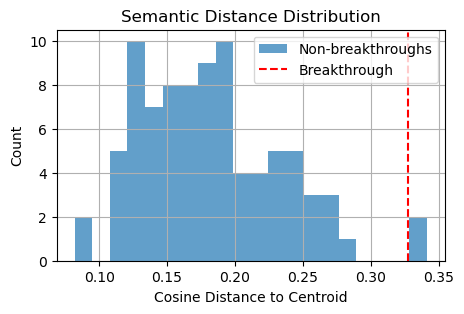

In [11]:
# Compute centroid of all previous patent excluding breakthrough
centroid = embeddings[1:].mean(axis=0, keepdims=True)

# Compute cosine distances to centroid
distances = cdist(embeddings, centroid, metric='cosine').flatten()
bt_dist = distances[0]
rest_dist = distances[1:]

# Compute emperical p-value of breakthrough patent
p_value = np.mean(rest_dist >= bt_dist)
print(f"Breakthrough cosine distance: {bt_dist:.4f}")
print(f"Empirical p-value: {p_value:.4f}")

# Plot distribution
plt.figure(figsize=(5, 3))
plt.hist(rest_dist, bins=20, alpha=0.7, label='Non-breakthroughs')
plt.axvline(bt_dist, color='red', linestyle='--', label='Breakthrough')

plt.xlabel("Cosine Distance to Centroid")
plt.ylabel("Count")
plt.title("Semantic Distance Distribution")
plt.legend()
plt.grid(True)
plt.show()

This simple analysis shows that Google’s PageRank patent is semantically distinct from all prior patents classified under CPC code Y10S707/99935, indicating that Pagerank introduced concepts or technical terms not present in earlier works.